In [12]:
from data import *
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from scipy.signal import savgol_filter
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes,InsetPosition,mark_inset


import seaborn as sns
import networkx as nx
from lattice.lattice_template import *
from lattice.lattice_parallel_numba import *
from scipy.optimize import curve_fit

In [14]:
%ls

data.py                                                          ic_gen.py
dataset_Feb-05-2021_17:28:20_J:-1.5_a:-2.4_64x64_1000flips.hdf5  __init__.py
dataset_Feb-06-2021_12:46:51_J:-1.5_a:-2.4_64x64_1000flips.hdf5  lattice/
dataset_Feb-06-2021_14:02:55_J:1.5_a:-2.4_64x64_1000flips.hdf5   parallel.py
datasets/                                                        __pycache__/
grid_run.py                                                      Test.ipynb
helper.py


In [15]:
fname = 'dataset_Feb-06-2021_14:02:55_J:1.5_a:-2.4_64x64_1000flips.hdf5'

reader = LatticeHDF5ReaderG(fname,100)

In [16]:
def ellipse(yp,a,b):
    xp = - np.sqrt((b**2)*(1 - (yp**2)/(a**2)))
    return xp
    
    
    
    
def ellipse_fit(ax,df, order = 0.05):
    df = df.sort_values('order')
    df_curve = df[df['order'].between(order-0.02, order+0.02)]
    x = df_curve['rho1'].to_numpy()
    y = df_curve['rho2'].to_numpy()

    #rotate by 45 degrees and center at (0.5,0.5)
    xp = (1/np.sqrt(2))*(x + y) - 1/np.sqrt(2)
    yp = (1/np.sqrt(2))*(y - x)
    #ax.scatter(x,y)
    popt, pcov = curve_fit(ellipse, yp[xp<-0.1], xp[xp<-0.1])
    
    return popt


def plot_ellipse(ax,popt):
    yp = np.linspace(-popt[0]+1e-6,popt[0]-1e-6,99)
    #print(yp)
    xp = ellipse(yp,*popt)
    #xp = np.concatenate([0],xp,[0])
    #yp = np.concatenate(-)
    x = (1/np.sqrt(2))*(xp + 1/np.sqrt(2) - yp) 
    y = (1/np.sqrt(2))*(xp + 1/np.sqrt(2) + yp)
    
    x_curve = x[y <= 1.0 - x]
    y_curve = y[y <= 1.0 - x]
    

    ax.plot(x_curve,y_curve,'r--')
    
    
def test_ellipse_fit():
    
    df = reader_j150.table.copy()
    df.set_index('a',inplace=True)
    fig, ax = plt.subplots()
    popt = ellipse_fit(ax,df)
    plot_ellipse(ax,(0.2,0.2))
    x = np.linspace(0,1.0,100)
    plt.plot(x,1-x)
    
#test_ellipse_fit()
axes_font_size = 14
title_font_size = 14
label_font_size = 14
marker_size = 3
pH_line_width = 1


def rho_phase_plot_contour(ax,df,reader,fig_let,poptm,show_bar = True):
    window = 21
    poly_order = 7
    
    #cmap = cm.PuOr
    ax.set_xlim([0,1.0])
    ax.set_ylim([0,1.0])
    ax.set_aspect('equal')
    ax.set_xlabel('$n_1$', size = label_font_size)
    ax.set_ylabel('$n_2$', size = label_font_size)
    
    
    levels = [-4,-3,-2,-1,0,2,4]
    cmap = sns.color_palette('Set2',len(levels),as_cmap=True) 
    #cmap = mcolors.ListedColormap(cmap)
    norm = mcolors.BoundaryNorm(levels, cmap.N)
    ax.tricontourf(df['rho1'],df['rho2'], df.index, cmap=cmap, norm=norm)
  
    #ax.set_title('J = {0}, K = {1}, {2}x{3}, {4} lattice flips'.format(
    #        reader.J,reader.K,reader.Lx,reader.Ly,reader.num_flips),size = 15)
    ax.set_title('{2} J = {0}, K = {1}'.format(
            -reader.attrs['J'],reader.attrs['K'],fig_let),size = title_font_size,y=1.0,pad=-14)

    #ax.xaxis.set_minor_locator(AutoMinorLocator())
    #ax.yaxis.set_minor_locator(AutoMinorLocator())
    dfp = df.reset_index()
    dfp = dfp.set_index('pH')
    #print(dfp)
    for i,tup in enumerate(dfp.groupby(level=0)):
        pH, data = tup
        if i%7 == 0:
            print(pH)
            data = data.sort_values(by='a')
            #ax.plot(savgol_filter(data['rho1'],window, poly_order),
            #    savgol_filter(data['rho2'],window, poly_order),'k',label ='pH = {}'.format(pH))
            ax.plot(data['rho1'],data['rho2'],'k--',label ='pH = {}'.format(pH), lw = pH_line_width)
            
    #ax.legend()
    ax.tick_params(labelsize = axes_font_size)
    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_major_locator(MultipleLocator(0.5))

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    
    popt = ellipse_fit(ax,df)
    plot_ellipse(ax,poptm)
    
    
    if show_bar:
        ax_left = 0.91
        ax_bottom = 0.25
        width = 0.05
        height = 0.65
        axin = ax.inset_axes([ax_left,ax_bottom,width,height])
        ax.text(ax_left - 0.15,ax_bottom + height/2 - 0.02, 'a', size = label_font_size)
        fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=axin)
        axin.yaxis.tick_left()

2.0
10.75


TypeError: Improper input: N=2 must not exceed M=1

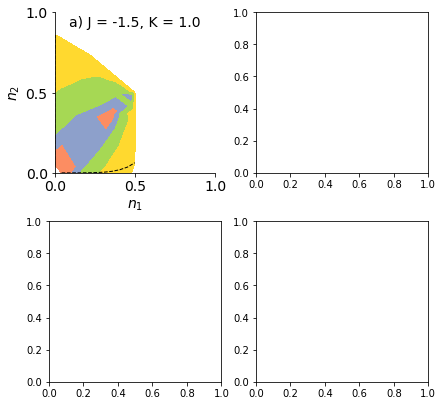

In [17]:
fig, _axs = plt.subplots(nrows=2, ncols=2,figsize=(6.8,6.8))
fig.subplots_adjust(hspace=0.3)
ax = _axs.flatten()

#a) j1 contour
df = reader.table.copy()
df.set_index('a',inplace=True)

rho_phase_plot_contour(ax[0],df,reader,'a)', (0.2,0.2), show_bar=True)

In [9]:
print(reader.table)

      a     pH      rho1      rho2     order c0_idx c1_idx
0   3.0   2.00  0.950840  0.003140  0.000947     a0    pH0
1   3.0   3.25  0.913105  0.047451  0.004287     a0    pH1
2   3.0   4.50  0.742021  0.245283  0.014331     a0    pH2
3   3.0   5.75  0.521177  0.477673  0.952590     a0    pH3
4   3.0   7.00  0.499709  0.500012  0.993672     a0    pH4
5   3.0   8.25  0.477085  0.521692  0.951238     a0    pH5
6   3.0   9.50  0.245327  0.741653  0.007302     a0    pH6
7   3.0  10.75  0.047031  0.914414  0.002676     a0    pH7
8   3.0  12.00  0.003247  0.950625  0.000078     a0    pH8
9   3.4   2.00  0.963945  0.003530  0.000435     a1    pH0
10  3.4   3.25  0.924814  0.049265  0.001042     a1    pH1
11  3.4   4.50  0.744509  0.246956  0.008257     a1    pH2
12  3.4   5.75  0.521865  0.477334  0.951055     a1    pH3
13  3.4   7.00  0.499900  0.499937  0.994011     a1    pH4
14  3.4   8.25  0.478057  0.521199  0.953547     a1    pH5
15  3.4   9.50  0.246658  0.744692  0.002542     a1    p